Please upload your CSV file.


Saving personal_finance_data.csv to personal_finance_data (1).csv
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


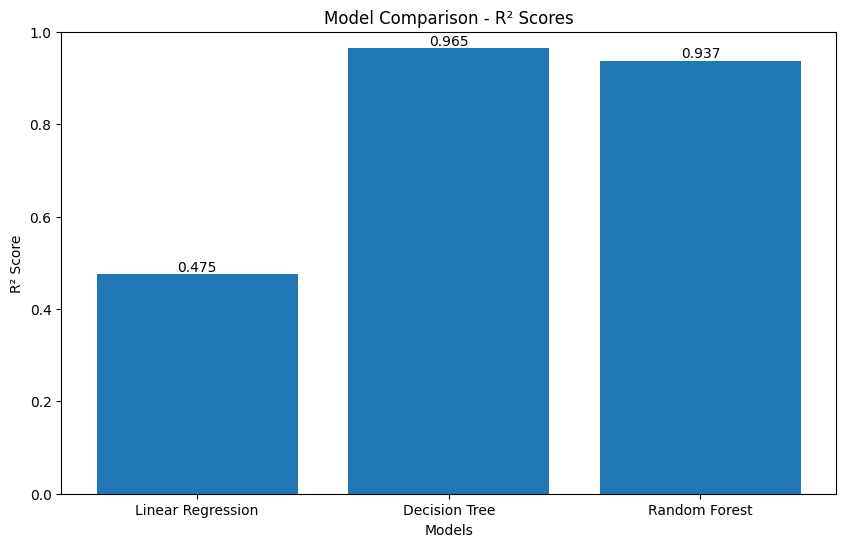

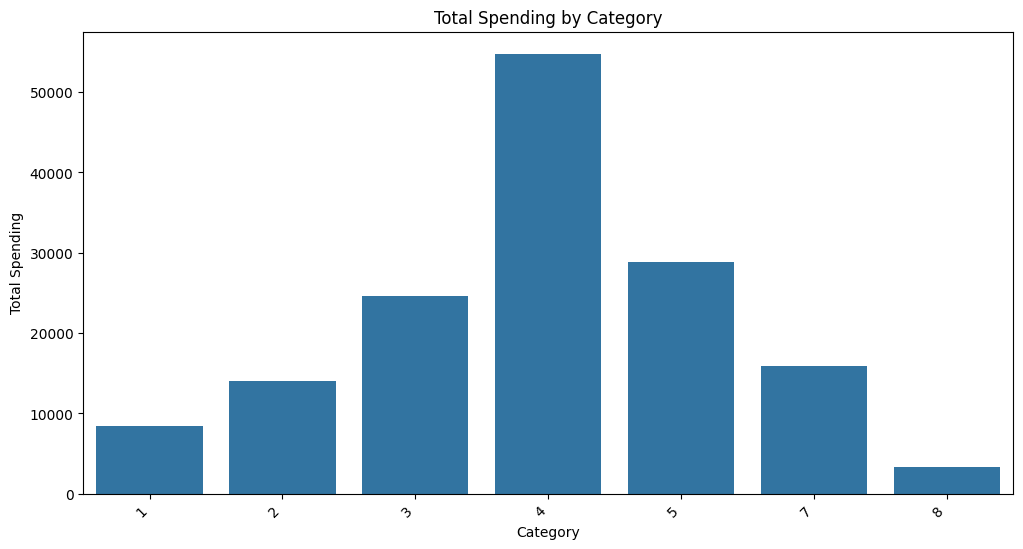

<ipython-input-20-417f3a519153>:132: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_expenses = pd.Series(predictions, index=pd.date_range('2024-01-01', periods=future_months, freq='M'))
<ipython-input-20-417f3a519153>:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenses['Month-Year'] = expenses['Date / Time'].dt.to_period('M')
<ipython-input-20-417f3a519153>:200: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_expenses, x='Month-Year', y='Debit/Credit', palette='viridis')



--- Financial Insights ---
Total Income: ₹698147.00
Total Expenses: ₹149853.28
Savings Rate: 78.54%

--- Top 3 Expense Categories ---
Category
4    54810.00
5    28887.00
3    24607.76
Name: Debit/Credit, dtype: float64

--- Spending Trends ---
Average Monthly Expense: ₹12487.77
High Spend Months (>1.5x average):
Date / Time
2021-04    20739.00
2021-12    24025.75
Freq: M, Name: Debit/Credit, dtype: float64
Low Spend Months (<0.5x average):
Date / Time
2021-08    5711.0
Freq: M, Name: Debit/Credit, dtype: float64

--- Future Projections ---
Predicted Average Monthly Expense: ₹9138.27
Predicted Total Expense for Next Year: ₹548296.19

--- Recommendations ---
1. You are saving effectively. Focus on investment strategies for growth.
2. Consider reducing spending in these top categories: [4, 5, 3].
3. Avoid overspending during high-spend months like:
   - April 2021 (₹20739.00)
   - December 2021 (₹24025.75)
4. Use projections to set a monthly budget of around ₹9138.27.
5. Monitor your sp

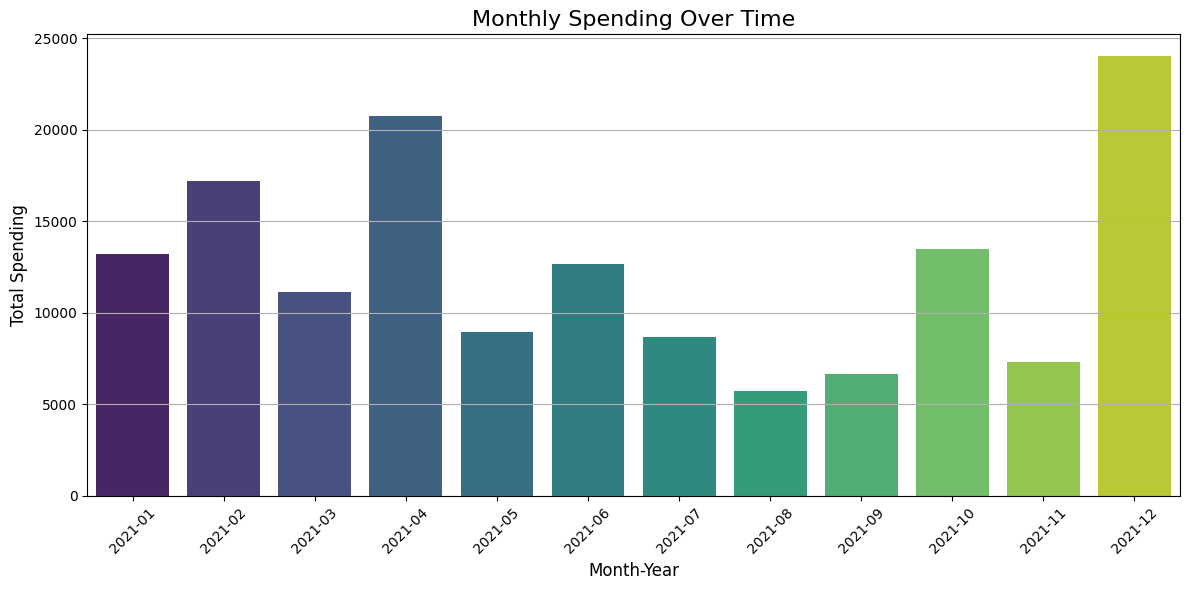

   Category  Debit/Credit  Cluster
0         0      13000.00        0
1         1       8396.00        0
2         2      14000.00        0
3         3      24607.76        0
4         4      54810.00        0
5         5      53124.00        0
6         6     165770.00        2
7         7      15873.80        0
8         8       3278.72        0
9         9     495140.00        1


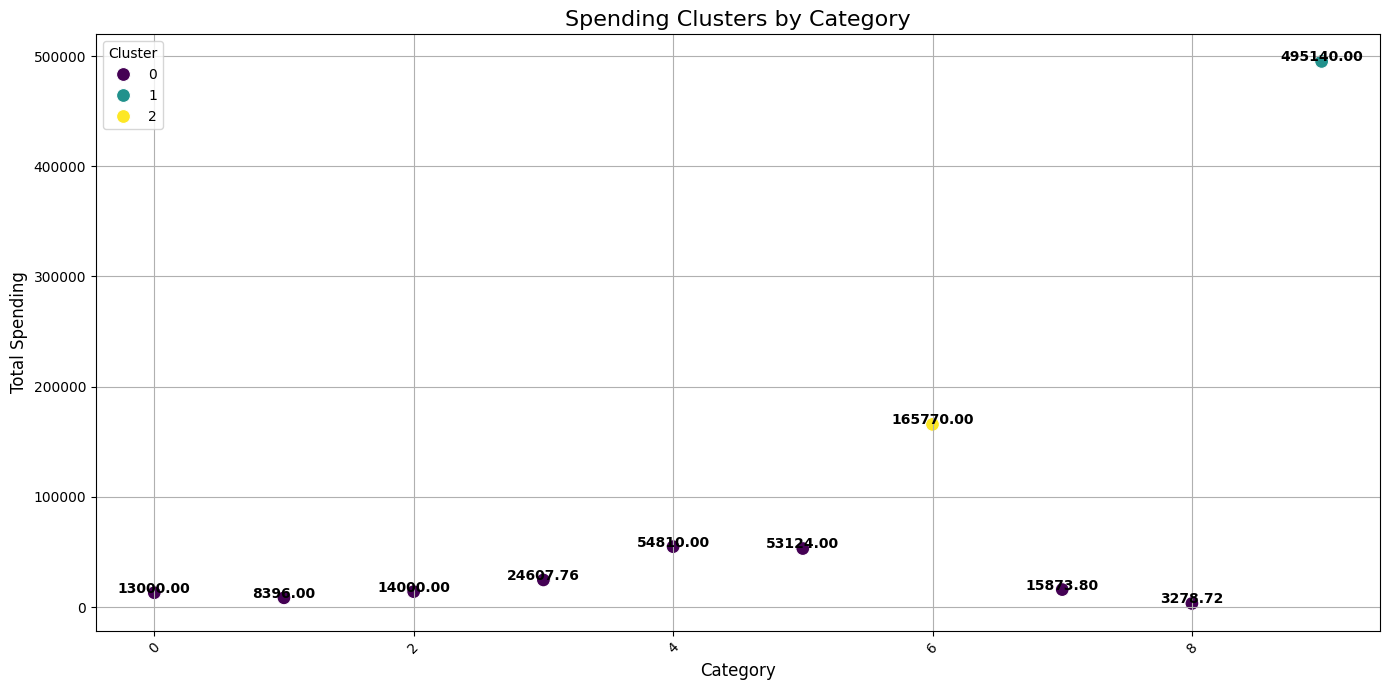

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import joblib
from google.colab import files
import os

# Load and preprocess the data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Date / Time'] = pd.to_datetime(data['Date / Time'], dayfirst=True)
    data['Year'] = data['Date / Time'].dt.year
    data['Month'] = data['Date / Time'].dt.month
    data['Day'] = data['Date / Time'].dt.day
    data['Weekday'] = data['Date / Time'].dt.weekday

    # Define label_encoders dictionary
    label_encoders = {}
    for col in ['Mode', 'Category', 'Sub category', 'Income/Expense']:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le  # Store the LabelEncoder object

    return data, label_encoders  # Return data and label_encoders

# Hyperparameter tuning for Random Forest
def tune_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for Random Forest: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Train and evaluate models
def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {'MSE': mse, 'R2': r2, 'Model': model}

        joblib.dump(model, f'{name.lower().replace(" ", "_")}_model.joblib')

    rf_best = tune_random_forest(X_train_scaled, y_train)
    y_pred_rf = rf_best.predict(X_test_scaled)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    results['Random Forest'] = {'MSE': mse_rf, 'R2': r2_rf, 'Model': rf_best}

    joblib.dump(rf_best, 'random_forest_model.joblib')

    return results, scaler

# Visualize model comparisons
def visualize_model_comparison(results):
    plt.figure(figsize=(10, 6))
    models = list(results.keys())
    r2_scores = [results[model]['R2'] for model in models]

    plt.bar(models, r2_scores)
    plt.title('Model Comparison - R² Scores')
    plt.xlabel('Models')
    plt.ylabel('R² Score')
    plt.ylim(0, 1)
    for i, v in enumerate(r2_scores):
        plt.text(i, v, f'{v:.3f}', ha='center', va='bottom')
    plt.show()

# Analyze spending patterns
def analyze_spending_patterns(data):
    expenses = data[data['Income/Expense'] == 0]
    category_spending = expenses.groupby('Category')['Debit/Credit'].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=category_spending.index, y=category_spending.values)
    plt.title('Total Spending by Category')
    plt.xlabel('Category')
    plt.ylabel('Total Spending')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    return category_spending

# Predict future expenses
def predict_future_expenses(model, scaler, future_months=12, years=5):
    future_months = years * 12
    future_data = pd.DataFrame({
        'Year': [2024 + (i // 12) for i in range(future_months)],
        'Month': [(i % 12) + 1 for i in range(future_months)],
        'Day': [1] * future_months,
        'Weekday': [0] * future_months,
        'Mode': [0] * future_months,
        'Category': [0] * future_months,
        'Sub category': [0] * future_months,
        'Income/Expense': [0] * future_months
    })

    future_data_scaled = scaler.transform(future_data)
    predictions = model.predict(future_data_scaled)

    future_expenses = pd.Series(predictions, index=pd.date_range('2024-01-01', periods=future_months, freq='M'))
    yearly_expenses = future_expenses.groupby(future_expenses.index.year).sum()

    return future_expenses, yearly_expenses

def generate_financial_insights(data, category_spending, future_expenses):
    # Total Income and Expenses
    total_income = data[data['Income/Expense'] == 1]['Debit/Credit'].sum()
    total_expenses = data[data['Income/Expense'] == 0]['Debit/Credit'].sum()
    savings_rate = (total_income - total_expenses) / total_income * 100 if total_income > 0 else 0

    # Monthly expense trends
    monthly_expenses = data[data['Income/Expense'] == 0].groupby(data['Date / Time'].dt.to_period('M'))['Debit/Credit'].sum()
    avg_monthly_expense = monthly_expenses.mean()
    high_spend_months = monthly_expenses[monthly_expenses > avg_monthly_expense * 1.5]
    low_spend_months = monthly_expenses[monthly_expenses < avg_monthly_expense * 0.5]

    # Insights generation
    print(f"\n--- Financial Insights ---")
    print(f"Total Income: ₹{total_income:.2f}")
    print(f"Total Expenses: ₹{total_expenses:.2f}")
    print(f"Savings Rate: {savings_rate:.2f}%")

    # Top Spending Categories
    print(f"\n--- Top 3 Expense Categories ---")
    print(category_spending.head(3))

    # Spending Trends
    print(f"\n--- Spending Trends ---")
    print(f"Average Monthly Expense: ₹{avg_monthly_expense:.2f}")
    print(f"High Spend Months (>1.5x average):")
    print(high_spend_months)
    print(f"Low Spend Months (<0.5x average):")
    print(low_spend_months)

    # Expense Projections
    avg_future_expense = future_expenses.mean()
    total_future_expense = future_expenses.sum()
    print(f"\n--- Future Projections ---")
    print(f"Predicted Average Monthly Expense: ₹{avg_future_expense:.2f}")
    print(f"Predicted Total Expense for Next Year: ₹{total_future_expense:.2f}")

    # Personalized Recommendations
    print(f"\n--- Recommendations ---")
    if savings_rate < 10:
        print("1. Your savings rate is low. Aim to save at least 20% of your income by cutting discretionary expenses.")
    elif savings_rate < 20:
        print("1. Your savings are on track, but consider increasing it to 30% for long-term goals.")
    else:
        print("1. You are saving effectively. Focus on investment strategies for growth.")

    print(f"2. Consider reducing spending in these top categories: {category_spending.head(3).index.tolist()}.")

    if not high_spend_months.empty:
        print("3. Avoid overspending during high-spend months like:")
        for month in high_spend_months.index:
            print(f"   - {month.strftime('%B %Y')} (₹{high_spend_months[month]:.2f})")

    print("4. Use projections to set a monthly budget of around ₹{:.2f}.".format(avg_future_expense))
    print("5. Monitor your spending regularly and adjust your habits based on these insights.")

# Visualize monthly spending over time
def visualize_monthly_spending(data):
    expenses = data[data['Income/Expense'] == 0]
    expenses['Month-Year'] = expenses['Date / Time'].dt.to_period('M')
    monthly_expenses = expenses.groupby('Month-Year')['Debit/Credit'].sum().reset_index()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=monthly_expenses, x='Month-Year', y='Debit/Credit', palette='viridis')
    plt.title('Monthly Spending Over Time', fontsize=16)
    plt.xlabel('Month-Year', fontsize=12)
    plt.ylabel('Total Spending', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Cluster spending by category
def cluster_spending_by_category(data):
    pivot_table = data.pivot_table(index='Category', values='Debit/Credit', aggfunc='sum').reset_index()

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pivot_table[['Debit/Credit']])

    kmeans = KMeans(n_clusters=3)
    pivot_table['Cluster'] = kmeans.fit_predict(scaled_data)

    print(pivot_table)

    plt.figure(figsize=(14, 7))
    sns.scatterplot(data=pivot_table, x='Category', y='Debit/Credit', hue='Cluster', palette='viridis', s=100)

    for index, row in pivot_table.iterrows():
        plt.text(row['Category'], row['Debit/Credit'] + 50, f'{row["Debit/Credit"]:.2f}',
                 horizontalalignment='center', fontsize=10, color='black', weight='bold')

    plt.title('Spending Clusters by Category', fontsize=16)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Total Spending', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Main function to execute the analysis
def main():
    print("Please upload your CSV file.")
    uploaded = files.upload()

    for file_name in uploaded.keys():
        file_path = file_name  # Get the file path from the uploaded file

    data, label_encoders = load_and_preprocess_data(file_path)

    X = data[['Year', 'Month', 'Day', 'Weekday', 'Mode', 'Category', 'Sub category', 'Income/Expense']]
    y = data['Debit/Credit']

    results, scaler = train_and_evaluate_models(X, y)
    visualize_model_comparison(results)

    category_spending = analyze_spending_patterns(data)

    rf_model = results['Random Forest']['Model']
    future_expenses, yearly_expenses = predict_future_expenses(rf_model, scaler)

    generate_financial_insights(data, category_spending, future_expenses)
    visualize_monthly_spending(data)
    cluster_spending_by_category(data)

# Execute the main function
if __name__ == "__main__":
    main()
